# BT4012 In-Class Kaggle Competition

Author: Loh Hong Tak Edmund | A0199943H

Python version: 3.9.5

**Prerequisites**

Make sure you have installed all of the following prerequisites on your development machine:
- Python 3.9.5
- Jupyter Notebook 6.4.4

**Installation**

The requirements.txt file should lists Python libraries that your notebooks depend on, and they will be installed using:

`pip install -r requirements.txt`

**Running Instructions**

Simply click Run All!

## Importing packages

In [1]:
# Exploratory Data Analysis
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from numpy import where
import seaborn as sns


# Oversampling
from imblearn.over_sampling import RandomOverSampler, SVMSMOTE, ADASYN


# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, auc, recall_score, precision_score 
from sklearn.ensemble import RandomForestClassifier
import xgboost

# Deep Learning
import tensorflow as tf
from tensorflow import keras
from keras import layers, backend
from keras.losses import binary_crossentropy
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator

# Settings
import warnings
warnings.filterwarnings("ignore")


## Loading Data Set

Previewing the dataset

In [2]:
ds = pd.read_csv('train.csv')
ds.head()

,r0c0,r0c1,r0c2,r0c3,r0c4,r0c5,r0c6,r0c7,r0c8,r0c9,...,r19c11,r19c12,r19c13,r19c14,r19c15,r19c16,r19c17,r19c18,r19c19,label
0,1,1,1,1,28,43,52,255,255,255,...,191,255,52,34,1,1,1,1,1,0
1,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,0
2,1,1,128,255,255,255,255,255,255,255,...,255,255,255,255,255,255,128,1,1,0
3,53,54,61,91,141,172,197,223,233,246,...,184,185,187,169,147,106,82,34,23,1
4,46,46,46,46,36,36,41,41,41,41,...,38,65,65,95,95,149,149,205,205,0


In [3]:
ds.describe()

,r0c0,r0c1,r0c2,r0c3,r0c4,r0c5,r0c6,r0c7,r0c8,r0c9,...,r19c11,r19c12,r19c13,r19c14,r19c15,r19c16,r19c17,r19c18,r19c19,label
count,72139.000000,72139.000000,72139.000000,72139.000000,72139.000000,72139.000000,72139.000000,72139.000000,72139.000000,72139.000000,...,72139.000000,72139.000000,72139.000000,72139.000000,72139.000000,72139.000000,72139.000000,72139.000000,72139.000000,72139.000000
mean,36.125383,51.473308,70.855279,82.032354,86.869142,96.391730,101.608728,108.712333,115.257752,119.014680,...,105.187416,101.996327,98.175689,94.994663,83.791611,79.024744,67.467084,49.497775,37.186349,0.090908
std,70.769428,83.545299,93.468985,99.787787,100.295541,103.128587,104.129642,103.806258,106.480366,107.572306,...,106.387324,102.402083,103.242319,102.317456,98.440790,97.781003,90.884177,82.706445,72.454911,0.287480
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
50%,1.000000,1.000000,2.000000,18.000000,33.000000,52.000000,67.000000,91.000000,96.000000,104.000000,...,69.000000,73.000000,60.000000,52.000000,26.000000,7.000000,1.000000,1.000000,1.000000,0.000000
75%,30.000000,80.000000,128.000000,171.000000,181.000000,208.000000,219.000000,226.000000,248.000000,255.000000,...,236.000000,213.000000,207.000000,199.000000,172.000000,163.000000,128.000000,73.000000,24.000000,0.000000
max,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,...,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,1.000000


In [4]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72139 entries, 0 to 72138
Columns: 401 entries, r0c0 to label
dtypes: int64(401)
memory usage: 220.7 MB


Sanity check for null values. There are no null values.

In [5]:
sum(ds.isnull().sum())

0

Sanity check for duplicated rows. There are 172 duplicated rows. We will remove them.

In [6]:
ds.duplicated().sum()

172

In [7]:
ds = ds.drop_duplicates()

Exploring the distribution of label counts in the dataset to check for label imbalance.

In [8]:
Counter(ds.label)

Counter({0: 65476, 1: 6491})

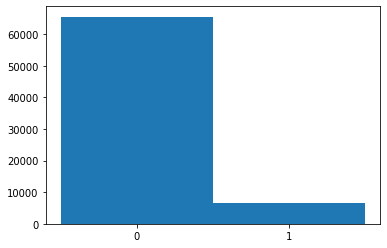

In [9]:
labels, values = zip(*Counter(ds.label).items())

indexes = np.arange(len(labels))
width = 1

plt.bar(indexes, values, width)
plt.xticks(indexes, labels)
plt.show()

The ratio of negative class to positive class is approximately 10:1. This reflects heavy imbalance between the two classes, which may affect the performance of our model. We will explore several oversampling methods to mitigate this imbalance.

## Preparing Training, Validation and Test Sets

In [10]:
X = ds.drop('label', axis=1)
y = ds.label.values

We split the dataset into 3 subsets: 
- Training set (0.72)
- Validation set (0.08)
- Test set (0.2)

We also normalise the data by dividing the data by 255. This scales the integer values to floats between 0 and 1. By normalising, we reduce the amount of computation resources needed to train the model subsequently. 

In [11]:
x_train_val, x_test, y_train_val, y_test = train_test_split(X, y, test_size=0.20,random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train_val,y_train_val, test_size=0.10,random_state=42)
x_train = x_train/255
x_val = x_val/255
x_test= x_test/255

## Previewing Images

In [12]:

# Function: reshape_mat(X)
# Input: 1d Array
# Return output: 2d Array
# Function Description: 
#   - Reshapes the 1d array input into a 20x20 2d array

def reshape_mat(X):
    X_mat = []
    for i in range(X.shape[0]):
        X_mat.append(np.reshape(X.iloc[i].tolist(), (20,20)).T)
    X_mat_arr = np.array(X_mat)
    X_mat_arr_ex = X_mat_arr[:,:,:,None]
    return X_mat_arr_ex


# Function: reshape_mat(image_batch, label_batch)
# Input: 2d Array, 1d Array
# Return output: None
# Function Description: 
#   - Plots 100 images in the image_batch along with their labels.

def show_batch(image_batch, label_batch):
    plt.figure(figsize=(20,20))
    r = reshape_mat(image_batch)
    for n in range(100):
        ax = plt.subplot(10,10,n+1)
        plt.imshow(r[n])
        plt.title(str(label_batch[n]))
        plt.axis("off")

Previewing images in the training set.

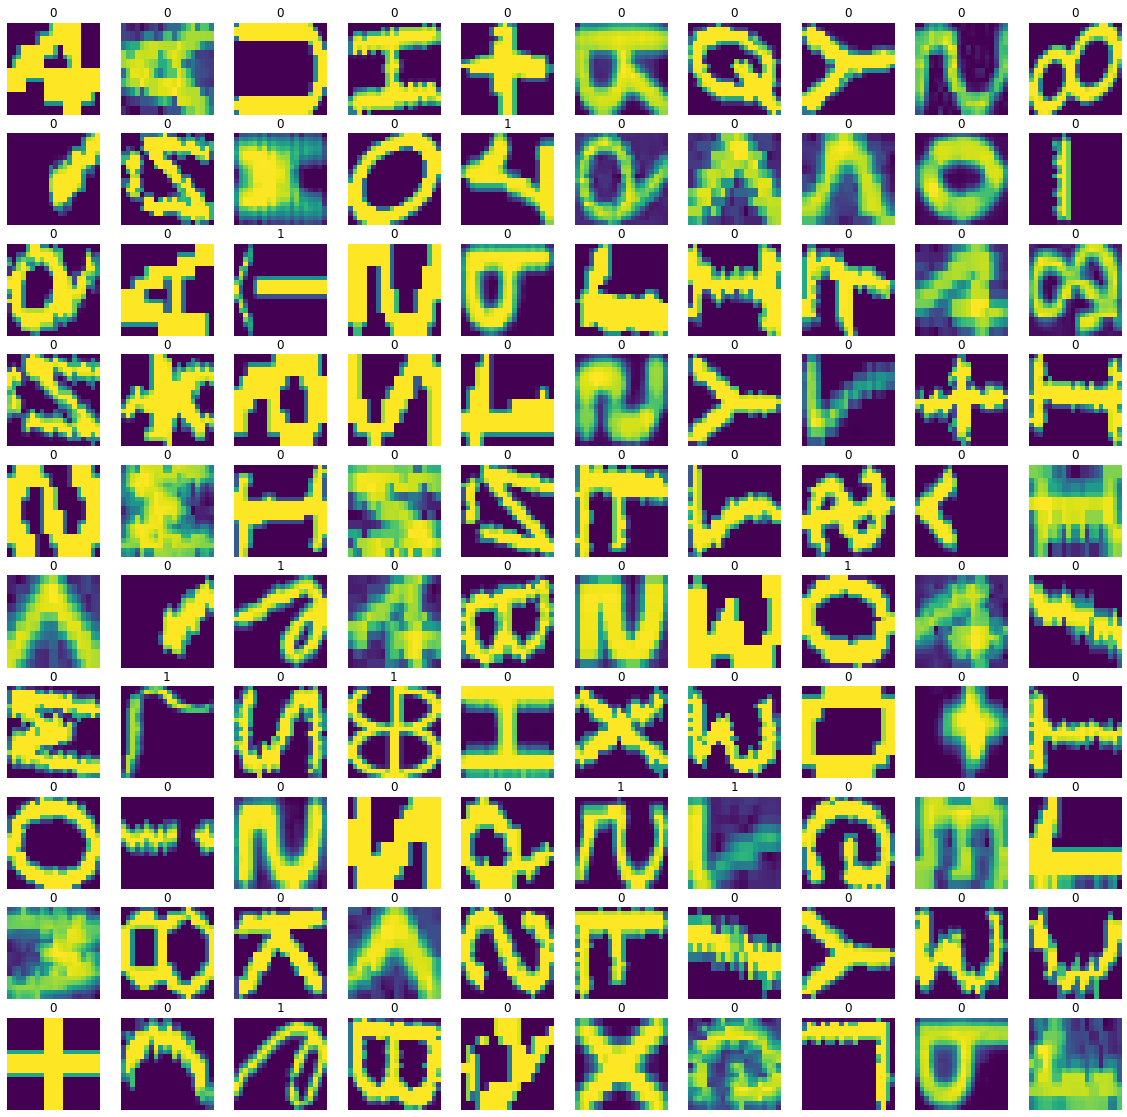

In [13]:
show_batch(x_train, y_train)


## Oversampling Train Data

As mentioned, the dataset is heavily imbalanced. We will explore 3 types of oversampling techniques. 

- Random Oversampling
    - Randomly adds more copies of the minority class.
- ADASYN Oversampling
    - Generates synthetic samples inversely proportional to the density of the examples in the minority class.
- SVM-SMOTE Oversampling
    - Incorporates SVM algorithms in approximating borderline areas between classes. Synthetic data will be randomly created along the lines between each minority class support vector and its nearest neighbours.  


In [14]:
x_train_randoversam, y_train_randoversam = RandomOverSampler(random_state=42).fit_resample(x_train,y_train)
x_train_adasyn, y_train_adasyn = ADASYN(random_state=42).fit_resample(x_train, y_train)
x_train_svmsmote, y_train_svmsmote = SVMSMOTE(random_state=42).fit_resample(x_train, y_train)


Checking label balance after oversampling

In [15]:
for y in [y_train, y_train_randoversam, y_train_adasyn, y_train_svmsmote]:
    print(Counter(y))

Counter({0: 47169, 1: 4646})
Counter({0: 47169, 1: 47169})
Counter({1: 47455, 0: 47169})
Counter({0: 47169, 1: 47169})


In [16]:
samples = {
    "normal": (x_train,y_train),
    "random_ovesampling": (x_train_randoversam, y_train_randoversam),
    "adasyn":(x_train_adasyn, y_train_adasyn),
    "svmsmote": (x_train_svmsmote, y_train_svmsmote)
}

## Neural Networks

### Neural Network Helper Functions

In [17]:
# Function: nn_predict_to_csv(model, name, cnn=False)
# Input: Tensorflow model, String name, Boolean cnn
# Return Output: Boolean
# Function Description: 
#   - Predicts the class probabilities of the test data with the input model.
#   - Formats the predicted probabilities into a dataframe and writes a CSV file meeting Kaggle specifications

def nn_predict_to_csv(model, name, cnn=False):
    test_ds = pd.read_csv("test.csv")
    Id = test_ds['Id'][:]
    test_ds = test_ds.drop("Id", axis=1)
    test_ds = test_ds/255
    pred = model.predict(test_ds)
    pred_df = pd.DataFrame({'Id':Id.values, 'Predicted':pred.flatten()}, columns=['Id', 'Predicted'])
    #print(pred_df)
    if cnn:
        pred_df.to_csv(f'CNN_{name}.csv', index=False)
    else:
        pred_df.to_csv(f'VNN_{name}.csv', index=False)
    return True



# Function: nn_model_score(name, model, x, y, cnn, output_csv=True)
# Input: String name, Tensorflow model, 2d Array x, 1d Array y, Boolean output_csv
# Return Output: List of Tensorflow model, Tensorflow history, Array model evaluation performance
# Function Description: 
#   - Pcompiles input Tensorflow model minimising binary cross-entropy loss
#   - Define callbacks: ReduceLROnPlateau and EarlyStopping
#   - Fits the model with x and y
#   - Evaluates model with held out test set
#   - if output_csv, save predictions to csv
#   - returns model, fit history and evaluation scores 

def nn_model_score(name, model, x, y, cnn, output_csv=True):
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy', 'AUC', 'Recall', 'Precision']
    )

    callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
                EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=12, restore_best_weights=True)]
    
    print("\n >>>> MODEL BUILDING ============================================================================ \n")
    history = model.fit(
        x, y, 
        epochs=64, 
        batch_size = 32, 
        validation_data=(x_val,y_val),
        callbacks=callbacks
    )
    print("\n >>>> MODEL EVALUATION ON TEST SET ============================================================================ \n")
    score = model.evaluate(x_test, y_test, batch_size=32)

    if output_csv:
        nn_predict_to_csv(model, name, cnn=cnn)

    return [model, history, score]

# Function: nn_get_res_df(res)
# Input: Dictionary res
# Return output: DataFrame res_dict
# Function Description: 
#   - Converts a dictionary of scores into a easy to read dataframe with labelled columns

def nn_get_res_df(res):
    res_dict = {}
    for name, hist in res.items():
        scores = hist[2]
        score_dict = {
            "loss": scores[0],
            "accuracy": scores[1],
            "auc": scores[2],
            "recall": scores[3],
            "precision": scores[4]
        }
        res_dict[name] = score_dict
    return pd.DataFrame(res_dict).T


# nn_pipeline(samps, model, cnn):
# Input: Array samps, Tensorflow model, Boolean cnn
# Return output: Dictionary results
# Function Description: 
#   - Pipeline function to train models on the various sampled training sets
#   - Outputs results of training

def nn_pipeline(samps, model, cnn):
    results = {}
    for name, xy in samps.items():
        print(f"\n Training {name}")
        hist = nn_model_score(name, model, xy[0], xy[1], cnn, output_csv=True)
        results[name] = hist
    return results



### Vanila Neural Network (Dense layers)

We create a vanila neural network containing only dense layers and dropouts. This model will serve as the baseline.

In [18]:
model_vanila = tf.keras.Sequential([
    layers.Dense(32, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(1, activation="sigmoid", name="predictions")
])

model_vanila_history = nn_pipeline(samples, model_vanila, cnn=False)


 Training normal

 >>>> MODEL BUILDING ============================================================================ 

Epoch 1/64
1620/1620 [==============================] - 16s 8ms/step - loss: 0.2641 - accuracy: 0.9109 - auc: 0.7585 - recall: 0.0097 - precision: 0.7143 - val_loss: 0.2301 - val_accuracy: 0.9258 - val_auc: 0.8673 - val_recall: 0.1900 - val_precision: 0.9519
Epoch 2/64
1620/1620 [==============================] - 14s 8ms/step - loss: 0.2280 - accuracy: 0.9242 - auc: 0.8334 - recall: 0.2611 - precision: 0.7106 - val_loss: 0.2022 - val_accuracy: 0.9330 - val_auc: 0.8898 - val_recall: 0.2917 - val_precision: 0.8994
Epoch 3/64
1620/1620 [==============================] - 14s 8ms/step - loss: 0.2127 - accuracy: 0.9289 - auc: 0.8580 - recall: 0.3295 - precision: 0.7297 - val_loss: 0.1883 - val_accuracy: 0.9439 - val_auc: 0.9031 - val_recall: 0.4722 - val_precision: 0.8367
Epoch 4/64
1620/1620 [==============================] - 13s 8ms/step - loss: 0.2027 - accuracy: 0.9330 -

### Previewing results of the Vanila Neural Network Pipeline

In [19]:
model_vanila_results = nn_get_res_df(model_vanila_history)
model_vanila_results

,loss,accuracy,auc,recall,precision
normal,0.161871,0.952689,0.933929,0.645770,0.801312
random_ovesampling,0.415842,0.812561,0.938028,0.909366,0.318350
adasyn,0.405759,0.818605,0.923804,0.895015,0.324036
svmsmote,0.332876,0.865361,0.938090,0.877644,0.395507


### Convolutional Neural Network

We create a Convolutional Neural Network to train on our image date. Since CNN's excel in classifying image data due to its ability to identify and isolate distinct local spatial features, we expect this model to perform well.

To reduce overfitting, we initialise the Convolutional and Dense layers with L2 regularisers.

In [22]:
model_cnn = tf.keras.Sequential([
    layers.Reshape(target_shape=(20, 20, 1), input_shape=(400,)),
    layers.Conv2D(32, (3, 3), activation = 'relu', kernel_regularizer=l2(0.0000001), padding='same'),
    layers.BatchNormalization(),
    layers.SpatialDropout2D(0.4),
    layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'),
    layers.Conv2D(64, (3, 3), activation = 'relu', kernel_regularizer=l2(0.0000001), padding='same'),
    layers.BatchNormalization(),
    layers.SpatialDropout2D(0.4),
    layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'),
    layers.Conv2D(128, (3, 3), activation = 'relu', kernel_regularizer=l2(0.0000001), padding='same'),
    layers.BatchNormalization(),
    layers.SpatialDropout2D(0.4),
    layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'),
    layers.Conv2D(256, (3, 3), activation = 'relu', kernel_regularizer=l2(0.0000001), padding='same'),
    layers.BatchNormalization(),
    layers.SpatialDropout2D(0.4),
    layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'),
    layers.Conv2D(512, (3, 3), activation = 'relu', kernel_regularizer=l2(0.0000001), padding='same'),
    layers.BatchNormalization(),
    layers.Flatten(),
    layers.Dropout(0.6),
    layers.Dense(128, activation='relu', kernel_regularizer=l2(0.0000001)),
    layers.Dropout(0.6),
    layers.Dense(16, activation='relu', kernel_regularizer=l2(0.0000001)),
    layers.Dense(1, activation='sigmoid')
])

model_cnn_history = nn_pipeline(samples, model_cnn, cnn=True)


 Training normal

 >>>> MODEL BUILDING ============================================================================ 

Epoch 1/64
1620/1620 [==============================] - 34s 20ms/step - loss: 0.2925 - accuracy: 0.9134 - auc: 0.6826 - recall: 0.1016 - precision: 0.6020 - val_loss: 0.2747 - val_accuracy: 0.9357 - val_auc: 0.8932 - val_recall: 0.3225 - val_precision: 0.9081
Epoch 2/64
1620/1620 [==============================] - 37s 23ms/step - loss: 0.2110 - accuracy: 0.9315 - auc: 0.8540 - recall: 0.3293 - precision: 0.7798 - val_loss: 0.2639 - val_accuracy: 0.9562 - val_auc: 0.9439 - val_recall: 0.6046 - val_precision: 0.8726
Epoch 3/64
1620/1620 [==============================] - 36s 22ms/step - loss: 0.1759 - accuracy: 0.9423 - auc: 0.9020 - recall: 0.4731 - precision: 0.8028 - val_loss: 0.1861 - val_accuracy: 0.9576 - val_auc: 0.9577 - val_recall: 0.5950 - val_precision: 0.9038
Epoch 4/64
1620/1620 [==============================] - 37s 23ms/step - loss: 0.1541 - accuracy: 0.94

### Previewing results of the Convolutional Neural Network Pipeline

In [23]:
model_cnn_results = nn_get_res_df(model_cnn_history)
model_cnn_results 

,loss,accuracy,auc,recall,precision
normal,0.053670,0.983396,0.991476,0.843656,0.972150
random_ovesampling,0.062457,0.981798,0.990628,0.928248,0.880372
adasyn,0.072477,0.978046,0.990345,0.910876,0.858974
svmsmote,0.069330,0.981659,0.989280,0.908610,0.893759


## Ensemble Methods

In this section, we will explore ensemble methods to classify our images. We explore 2 popular models:
- XGBoost
    - Employs an ensemble of gradient boosted decision trees to classify, with a focus on speed and performance.
- RandomForest.
    - Employs an ensemble of uncorrelated decision trees to classify


### Ensemble Methods Helper Functions

In [22]:
# Function: ens_get_bceloss(pred,true)
# Input: Array predicted probabilities, Array true labels
# Return output: Float mean_ce
# Function Description: 
#   - Returns the binary cross-entropy loss of a set of predicted probabilities against the true labels.

def ens_get_bceloss(pred,true):
    y_true = backend.variable(true)
    y_pred = backend.variable(pred)
    mean_ce = backend.eval(binary_crossentropy(y_true, y_pred))
    return mean_ce


# Function: ens_get_auc(y_pred_proba, y)
# Input: Array predicted probabilities, Array true labels
# Return output: Float auc
# Function Description: 
#   - Returns the AUC score of a set of predicted probabilities against the true labels.

def ens_get_auc(y_pred_proba, y):
    [fpr, tpr, thr] = roc_curve(y, y_pred_proba)
    return auc(fpr, tpr)


# Function: ens_get_results_dict(model)
# Input: Model model
# Return output: Dictionary score_dict
# Function Description: 
#   - Predicts the class probabilities of the held-out test set
#   - Returns scores of evaluating the model on the held-out test set

def ens_get_results_dict(model):
    y_pred = model.predict(x_test)
    y_pred_proba = model.predict_proba(x_test)[:,1]
    score_dict = {
        "loss": ens_get_bceloss(y_pred_proba, y_test),
        "accuracy": accuracy_score(y_test, y_pred),
        "auc": ens_get_auc(y_pred_proba, y_test),
        "recall": recall_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred)
    }
    return score_dict


# Function: ens_pred_test_to_csv(model, name, xgb=False)
# Input: Model model, String name, Boolean xgb
# Return output: None
# Function Description: 
#   - Loads the unseen test data
#   - Predicts class probabilities
#   - Formats output into a dataframe
#   - Writes a CSV file with specifications according to Kaggle.

def ens_pred_test_to_csv(model, name, xgb=False):
    test_ds = pd.read_csv("test.csv")
    Id = test_ds['Id'][:]
    test_ds = test_ds.drop("Id", axis=1)
    test_ds = test_ds/255
    pred_proba = model.predict_proba(test_ds)
    pred_proba_1 = []
    for i in pred_proba:
        pred_proba_1.append(i[1])
    pred_df = pd.DataFrame({'Id':Id.values, 'Predicted':pred_proba_1}, columns=['Id', 'Predicted'])
    #print(pred_df)
    if xgb:
        pred_df.to_csv(f'xgb_{name}.csv', index=False)
    else:
        pred_df.to_csv(f'rf_{name}.csv', index=False)



# Function: ens_pipeline(samps,model,csv_output=True,xgb=False)
# Input: Array samps, Model model, Boolean csv_outpoot, Boolean xgb
# Return output: DataFrame res
# Function Description: 
#   - Pipeline function to train the model on the several sampled training sets
#   - Outputs an easy to read dataframe with the relevant scores

def ens_pipeline(samps,model,csv_output=True,xgb=False):
    res = {}
    for name, sample in samps.items():
        print(f"\n Training {name} in progress ")
        model.fit(sample[0],sample[1])
        score = ens_get_results_dict(model)
        res[name] = score
        print(f"\n Training {name} completed ")
        if csv_output:
            ens_pred_test_to_csv(model, name, xgb=xgb)
    print("\n Pipeline Completed Successfully")
    return pd.DataFrame(res).T




### Building XGBoost Model Pipeline

In [23]:
xgb = xgboost.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_res = ens_pipeline(samples, xgb,xgb=True)
xgb_res


 Training normal in progress 

 Training normal completed 

 Training random_ovesampling in progress 

 Training random_ovesampling completed 

 Training adasyn in progress 

 Training adasyn completed 

 Training svmsmote in progress 

 Training svmsmote completed 

 Pipeline Completed Successfully


,loss,accuracy,auc,recall,precision
normal,0.075171,0.973600,0.987773,0.750755,0.952107
random_ovesampling,0.077299,0.973044,0.984978,0.842900,0.861111
adasyn,0.098090,0.965263,0.975970,0.817976,0.807004
svmsmote,0.104638,0.963874,0.973277,0.813444,0.797778


### Building RandomForest Model Pipeline

In [24]:
rf = RandomForestClassifier(n_estimators=150, random_state=42)
rf_res = ens_pipeline(samples,rf, xgb=False)
rf_res


 Training normal in progress 

 Training normal completed 

 Training random_ovesampling in progress 

 Training random_ovesampling completed 

 Training adasyn in progress 

 Training adasyn completed 

 Training svmsmote in progress 

 Training svmsmote completed 

 Pipeline Completed Successfully


,loss,accuracy,auc,recall,precision
normal,0.111069,0.959497,0.989442,0.577039,0.970775
random_ovesampling,0.109924,0.962832,0.990123,0.623867,0.957126
adasyn,0.147697,0.966375,0.981978,0.756042,0.861446
svmsmote,0.131697,0.970126,0.985507,0.760574,0.899107


## Results Summary

### Vanila Neural Network

In [25]:
model_vanila_results

,loss,accuracy,auc,recall,precision
normal,0.161871,0.952689,0.933929,0.645770,0.801312
random_ovesampling,0.415842,0.812561,0.938028,0.909366,0.318350
adasyn,0.405759,0.818605,0.923804,0.895015,0.324036
svmsmote,0.332876,0.865361,0.938090,0.877644,0.395507


In [29]:
model_vanila_results.to_csv('vanila_nn_results.csv', index=False)

### Convolutional Neural Network

In [65]:
model_cnn_results

,loss,accuracy,auc,recall,precision
0,0.053670,0.983396,0.991476,0.843656,0.972150
1,0.062457,0.981798,0.990628,0.928248,0.880372
2,0.072477,0.978046,0.990345,0.910876,0.858974
3,0.069330,0.981659,0.989280,0.908610,0.893759


In [36]:
model_cnn_results.to_csv('cnn_results.csv', index=False)

### XGBoost

In [27]:
xgb_res

,loss,accuracy,auc,recall,precision
normal,0.075171,0.973600,0.987773,0.750755,0.952107
random_ovesampling,0.077299,0.973044,0.984978,0.842900,0.861111
adasyn,0.098090,0.965263,0.975970,0.817976,0.807004
svmsmote,0.104638,0.963874,0.973277,0.813444,0.797778


In [31]:
xgb_res.to_csv('xgb_results.csv', index=False)

### RandomForest Results

In [28]:
rf_res

,loss,accuracy,auc,recall,precision
normal,0.111069,0.959497,0.989442,0.577039,0.970775
random_ovesampling,0.109924,0.962832,0.990123,0.623867,0.957126
adasyn,0.147697,0.966375,0.981978,0.756042,0.861446
svmsmote,0.131697,0.970126,0.985507,0.760574,0.899107


In [32]:
rf_res.to_csv('rf_results.csv', index=False)